In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wrds
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats

## The Data

In [ ]:
borisovadb=wrds.Connection()

In [ ]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1928-01-01'
            and mcaldt<='2004-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1928-01-01' and date<='2004-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1928' and '12/31/2004'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data.to_csv('data.csv', sep=';',index=False) # export data

## Betting against Beta strategy (BaB)

In [146]:
data_bab = pd.read_csv('data.csv', sep=';')
data_bab=data_bab.sort_values(['permno','date']).reset_index(drop=True)
data_bab

,permno,date,shrcd,exchcd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10001,2009-12-31,11,2,0.162621,4361.0,10.3000,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443
1,10001,2010-01-29,11,2,-0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185
2,10001,2010-02-26,11,2,-0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683
3,10001,2010-03-31,11,2,0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-04-30,11,2,0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439403,93426,2023-08-31,11,1,-0.037156,12581.0,36.0200,453167.6200,422469.9800,0.004463,-0.020605,1,-0.041619,-0.025068
1439404,93426,2023-09-29,11,1,-0.067740,12581.0,33.5800,422469.9800,376423.5200,0.004472,-0.047390,1,-0.072212,-0.051862
1439405,93426,2023-10-31,11,1,-0.108993,12581.0,29.9200,376423.5200,381429.9000,0.004475,-0.028867,1,-0.113468,-0.033342
1439406,93426,2023-11-30,11,1,0.019051,12510.0,30.4900,381429.9000,426215.7000,0.004455,0.092057,1,0.014596,0.087602


### Time-varying market Beta 

In [147]:
window_size = 60 # 5-year rolling window

data_bab['date'] = pd.to_datetime(data_bab['date'])

data_bab = data_bab.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_bab['N'] = data_bab.groupby(['permno'])['date'].transform('count')
data_bab = data_bab[data_bab['N']>60].copy() # consider only those that have more than 5-years of data

#Compute covariance matrix of excess stock and market returns
cov_nm = data_bab.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window_size, min_periods=36).cov()
# Compute beta from OLS regression (COV(Rn_e, Rm_e)/VAR(Rm_e))
beta = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta = beta.dropna()
beta = beta.reset_index().rename(columns={'Rm_e': 'beta'})

# Merge beta dataframe into data dataframe
beta = beta.set_index(['date', 'permno']).groupby('permno').shift(-1)
data_bab = pd.merge(data_bab, beta, on=['date','permno'], how='left')

# Winsorize the beta at 5 and 95%
data_bab['beta'] = data_bab['beta'].clip(lower = data_bab['beta'].quantile(0.05), upper = data_bab['beta'].quantile(0.95))

In [148]:
data_bab = data_bab.dropna(subset='beta').copy()
data_bab.date.nunique()

683

### Portfolio Sorts
#### Equall Weighted

In [149]:
data_bab = data_bab.dropna(subset='beta').copy()
# Compute beta decile for each date
data_bab['beta_decile'] = data_bab.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))
# Compute weight for equal-weight porfolio for each date-decile portfolio
data_bab['ew_decile'] = 1 / data_bab.groupby(['date','beta_decile'])['permno'].transform('count')

# Compute weighted return of each portfolio
data_bab['ew_decile_ret'] = data_bab['ew_decile'] * data_bab['Rn']
data_bab['ew_decile_excess_ret'] = data_bab['ew_decile'] * data_bab['Rn_e']
ret_ew = data_bab.groupby(['date','beta_decile'])['ew_decile_ret'].sum().reset_index()

# Compute excess return
ew_decile_excess_ret = data_bab.groupby(['date', 'beta_decile'])['ew_decile_excess_ret'].sum().reset_index(name='ew_decile_excess_ret')
ret_ew = ret_ew.merge(ew_decile_excess_ret, on=['date', 'beta_decile'])
ret_ew

,date,beta_decile,ew_decile_ret,ew_decile_excess_ret
0,1966-12-30,0,0.028308,0.024583
1,1966-12-30,1,0.015525,0.011800
2,1966-12-30,2,0.020243,0.016518
3,1966-12-30,3,0.015106,0.011381
4,1966-12-30,4,0.033945,0.030221
...,...,...,...,...
6612,2023-11-30,5,0.083907,0.079452
6613,2023-11-30,6,0.115302,0.110847
6614,2023-11-30,7,0.127456,0.123001
6615,2023-11-30,8,0.073287,0.068832


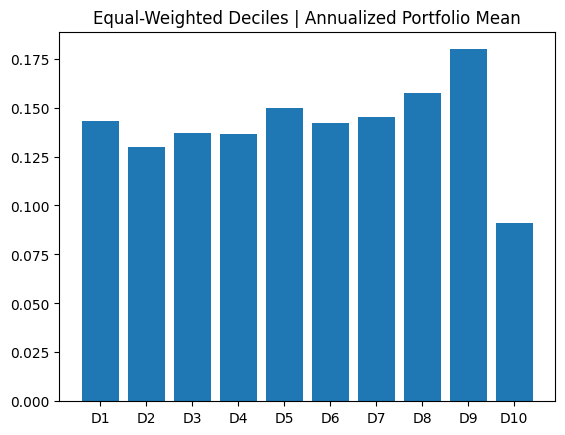

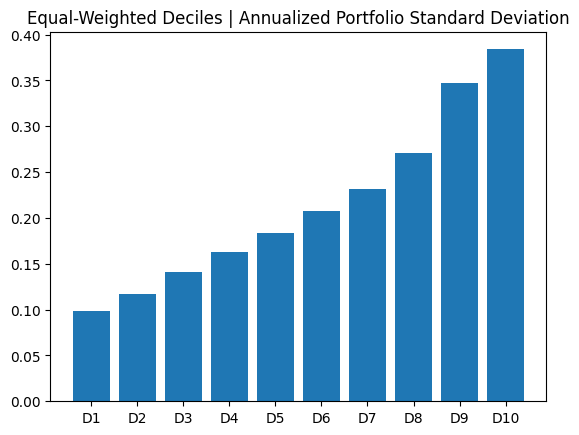

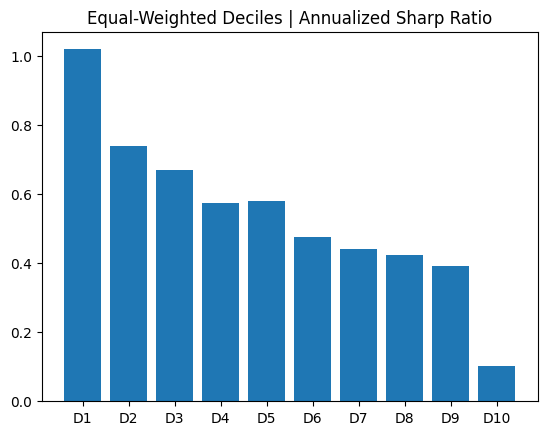

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [150]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew.groupby('beta_decile')['ew_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [151]:
data_bab = data_bab.dropna(subset='beta').copy()
data_bab['beta_decile'] = data_bab.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# Compute weights for value-weighted portfolios
data_bab['vw_decile'] = data_bab['mcap'] / data_bab.groupby(['date','beta_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
data_bab['vw_decile_ret'] = data_bab['vw_decile'] * data_bab['Rn']
data_bab['vw_decile_excess_ret'] = data_bab['vw_decile'] * data_bab['Rn_e']
ret_vw = data_bab.groupby(['date','beta_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = data_bab.groupby(['date', 'beta_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw = ret_vw.merge(vw_decile_excess_ret, on=['date', 'beta_decile'])
ret_vw

,date,beta_decile,vw_decile_ret,vw_decile_excess_ret
0,1966-12-30,0,0.026202,0.022477
1,1966-12-30,1,0.000127,-0.003598
2,1966-12-30,2,-0.009434,-0.013159
3,1966-12-30,3,0.001406,-0.002319
4,1966-12-30,4,0.008252,0.004527
...,...,...,...,...
6612,2023-11-30,5,0.132185,0.127730
6613,2023-11-30,6,0.124984,0.120529
6614,2023-11-30,7,0.170734,0.166279
6615,2023-11-30,8,0.093756,0.089301


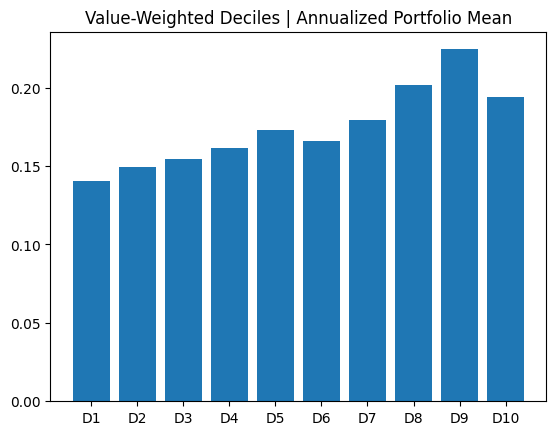

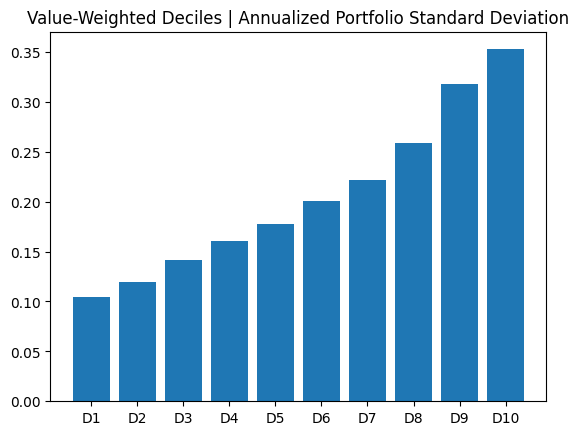

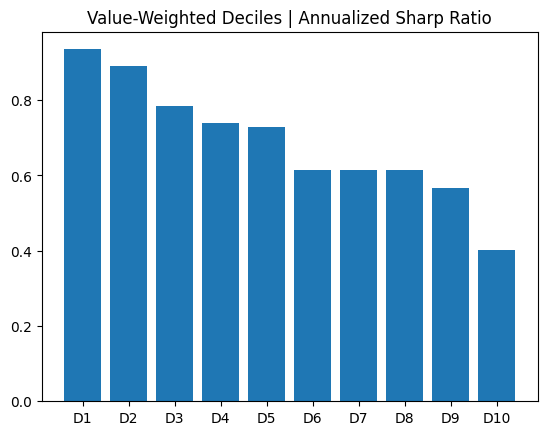

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [152]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw.groupby('beta_decile')['vw_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Constructing the BAB factor

In [153]:
# Compute z
data_bab['z'] = data_bab.groupby('date')['beta'].transform(lambda x: x.rank())
# Compute z-hat
data_bab['z_mean'] = data_bab.groupby('date')['z'].transform('mean')
# Calculate (z - z-hat)
data_bab['z_'] = data_bab['z'] - data_bab['z_mean']
# Calculate k
data_bab['k'] = np.abs(data_bab['z_'])
data_bab['k'] = 2/data_bab.groupby('date')['k'].transform('sum')
# Compute high-beta and low-beta portfolios weights
data_bab['w_H'] = data_bab['k'] * data_bab['z_'] * (data_bab['z_']>0) 
data_bab['w_L'] = -data_bab['k'] * data_bab['z_'] * (data_bab['z_']<0) 

In [154]:
# Compute betas
data_bab['beta_H'] = data_bab['w_H'] * data_bab['beta']
data_bab['beta_L'] = data_bab['w_L'] * data_bab['beta']
# Compute Excess Returns
data_bab['R_H_e'] = data_bab['w_H'] * data_bab['Rn_e']
data_bab['R_L_e'] = data_bab['w_L'] * data_bab['Rn_e']
# Sum up all returns and betas for each date
BAB = data_bab.groupby('date')[['R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
# Compute BAB return
BAB['R_BAB'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H'] 


In [156]:
tmp = pd.merge(BAB,data_bab[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1
tmp = tmp.dropna()
reg = sm.OLS(tmp['R_BAB'], tmp[['const', 'Rm_e']]).fit()

print('----------------------------------------')
print(f"| Annualized mean          | {np.round(tmp['R_BAB'].mean() * 12, 5)}  |")
print(f"| Annualized std           | {np.round(tmp['R_BAB'].std() * np.sqrt(12), 5)}  |")
print(f"| Annualized Sharp Ratio   | {np.round(tmp['R_BAB'].mean() / tmp['R_BAB'].std() * np.sqrt(12), 5)}  |")
print(f"| Annualized CAPM alpha    | {np.round(reg.params['const'] * 12, 5)}  |")
print(f"| BAB factor               | {np.round(reg.params['Rm_e'], 5)} |")
print('----------------------------------------')

----------------------------------------
| Annualized mean          | 0.11022  |
| Annualized std           | 0.13188  |
| Annualized Sharp Ratio   | 0.83582  |
| Annualized CAPM alpha    | 0.12376  |
| BAB factor               | -0.20178 |
----------------------------------------


## Momentum Strategy (Mom)

In [158]:
# Reset Data
data_mom = pd.read_csv('data.csv', sep=';')
data_mom=data_mom.sort_values(['permno','date']).reset_index(drop=True)

### Portfolio Sorts

In [159]:
# Compute cumulative return for each permco
tmp = data_mom.set_index('date').groupby('permno')['Rn'].rolling(window=11, closed='left').apply(lambda x: (1 + x).prod() - 1).reset_index()
tmp = tmp.dropna()
tmp = tmp.reset_index().rename(columns={'Rn': 'lagged_11_month_ret'})
data_mom = pd.merge(data_mom, tmp, on=['date','permno'], how='left')
# Compute Deciles of returns for each date
data_mom['lagged_11_month_ret_decile'] = data_mom.groupby('date')['lagged_11_month_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

#### Equally Weighted 

In [160]:
# Calculate weights for equal-weighted portfolios for date-decile pair
data_mom['ew_lagged_decile'] = 1 / data_mom.groupby(['date','lagged_11_month_ret_decile'])['permno'].transform('count')
# Compute returns of each portfolio
data_mom['ew_lagged_decile_ret'] = data_mom['ew_lagged_decile'] * data_mom['Rn']
data_mom['ew_lagged_decile_excess_ret'] = data_mom['ew_lagged_decile'] * data_mom['Rn_e']
ret_ew_lagged = data_mom.groupby(['date','lagged_11_month_ret_decile'])['ew_lagged_decile_ret'].sum().reset_index()
# Excess return
ew_lagged_decile_excess_ret = data_mom.groupby(['date', 'lagged_11_month_ret_decile'])['ew_lagged_decile_excess_ret'].sum().reset_index(name='ew_lagged_decile_excess_ret')
ret_ew_lagged = ret_ew_lagged.merge(ew_lagged_decile_excess_ret, on=['date', 'lagged_11_month_ret_decile'])
ret_ew_lagged

,date,lagged_11_month_ret_decile,ew_lagged_decile_ret,ew_lagged_decile_excess_ret
0,1964-12-31,0.0,-0.047042,-0.049898
1,1964-12-31,1.0,-0.005004,-0.007860
2,1964-12-31,2.0,-0.006657,-0.009513
3,1964-12-31,3.0,-0.001412,-0.004268
4,1964-12-31,4.0,-0.007112,-0.009967
...,...,...,...,...
7085,2023-12-29,5.0,0.062733,0.058249
7086,2023-12-29,6.0,0.084082,0.079598
7087,2023-12-29,7.0,0.079372,0.074887
7088,2023-12-29,8.0,0.095368,0.090884


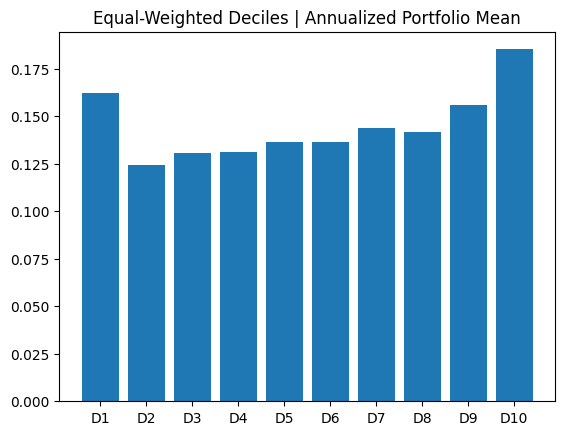

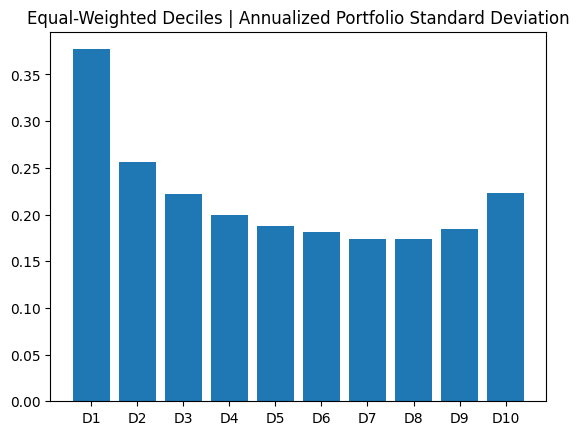

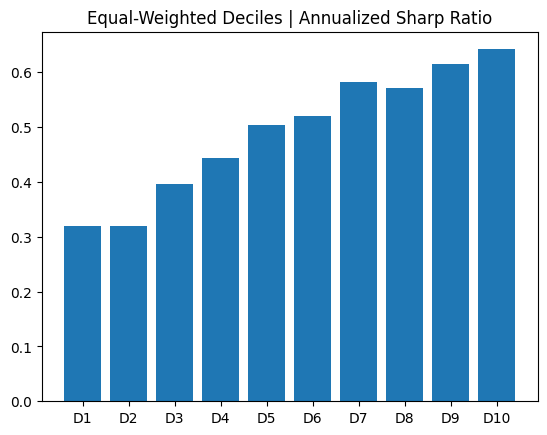

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [161]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [162]:
# Compute weights for value-weighted portfolios
data_mom['vw_lagged_decile'] = data_mom['mcap'] / data_mom.groupby(['date','lagged_11_month_ret_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
data_mom['vw_lagged_decile_ret'] = data_mom['vw_lagged_decile'] * data_mom['Rn']
data_mom['vw_lagged_decile_excess_ret'] = data_mom['vw_lagged_decile'] * data_mom['Rn_e']
ret_vw_lagged = data_mom.groupby(['date','lagged_11_month_ret_decile'])['vw_lagged_decile_ret'].sum().reset_index()
vw_lagged_decile_excess_ret = data_mom.groupby(['date', 'lagged_11_month_ret_decile'])['vw_lagged_decile_excess_ret'].sum().reset_index(name='vw_lagged_decile_excess_ret')
ret_vw_lagged = ret_vw_lagged.merge(vw_lagged_decile_excess_ret, on=['date', 'lagged_11_month_ret_decile'])
ret_vw_lagged

,date,lagged_11_month_ret_decile,vw_lagged_decile_ret,vw_lagged_decile_excess_ret
0,1964-12-31,0.0,-0.006046,-0.008901
1,1964-12-31,1.0,0.001358,-0.001498
2,1964-12-31,2.0,0.015222,0.012367
3,1964-12-31,3.0,0.008454,0.005598
4,1964-12-31,4.0,0.002129,-0.000726
...,...,...,...,...
7085,2023-12-29,5.0,0.029044,0.024560
7086,2023-12-29,6.0,0.050089,0.045604
7087,2023-12-29,7.0,0.052888,0.048403
7088,2023-12-29,8.0,0.047276,0.042792


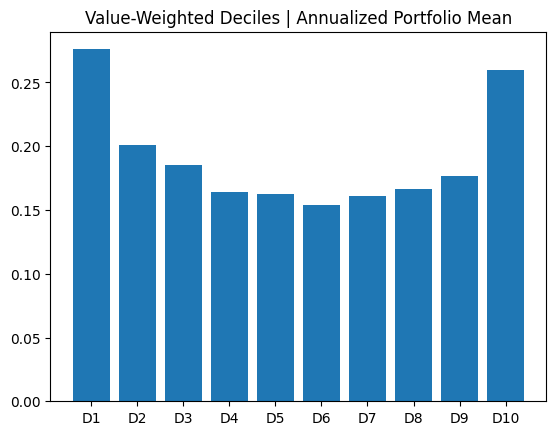

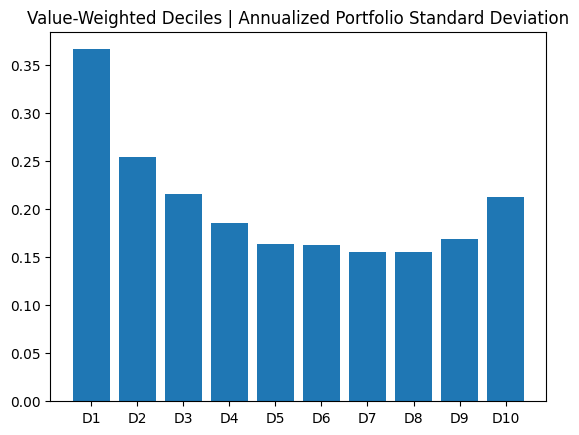

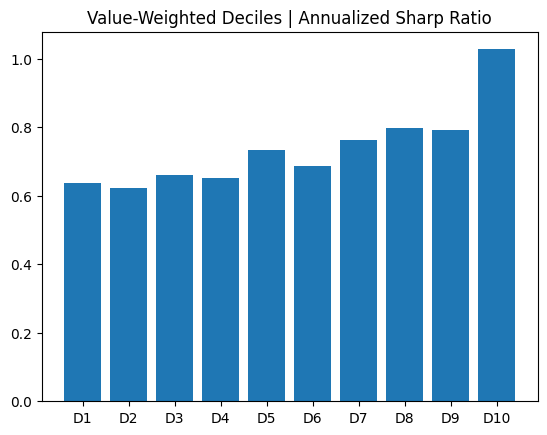

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [163]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Momentum Strategy Portfolio

In [14]:
def calculate_portfolio_metrics(returns, excess_returns):
    mean_return = returns.mean() * 12
    std_dev = returns.std() * np.sqrt(12)
    sharpe_ratio = excess_returns.mean() * 12 / std_dev
    return mean_return, std_dev, sharpe_ratio

In [164]:
long = data_mom[data_mom['lagged_11_month_ret_decile'].isin([7,8,9])].copy()
short = data_mom[data_mom['lagged_11_month_ret_decile'].isin([0,1,2])].copy()

#### Equally Weighted Portfolio

In [165]:
# Long portfolio: Equal-weighted average of the top three deciles (Deciles 7, 8 and 9)
ew_long_rets = long.groupby('date')['Rn'].mean() 
ew_long_excess_rets = long.groupby('date')['Rn_e'].mean() 
# Short portfolio: Equal-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
ew_short_rets = short.groupby('date')['Rn'].mean() 
ew_short_excess_rets = short.groupby('date')['Rn_e'].mean() 
# Compute the return of the momentum strategy as the difference between the long and short portfolios' returns
ew_momentum_rets = ew_long_rets - ew_short_rets

In [166]:
ew_long_mean, ew_long_std, ew_long_sharpe = calculate_portfolio_metrics(ew_long_rets, ew_long_excess_rets)
ew_short_mean, ew_short_std, ew_short_sharpe = calculate_portfolio_metrics(ew_short_rets, ew_short_excess_rets)
ew_momentum_mean, ew_momentum_std, ew_momentum_sharpe = calculate_portfolio_metrics(ew_momentum_rets, ew_long_excess_rets - ew_short_excess_rets)
ew_t_stat, ew_p_value = stats.ttest_1samp(ew_momentum_rets, 0)

print(f"Equal-Weighted Portfolio Metrics:")
print(f"Long Portfolio: Mean = {ew_long_mean:.2%}, Std Dev = {ew_long_std:.2%}, Sharpe Ratio = {ew_long_sharpe:.2f}")
print(f"Short Portfolio: Mean = {ew_short_mean:.2%}, Std Dev = {ew_short_std:.2%}, Sharpe Ratio = {ew_short_sharpe:.2f}")
print(f"Momentum Strategy: Mean = {ew_momentum_mean:.2%}, Std Dev = {ew_momentum_std:.2%}, Sharpe Ratio = {ew_momentum_sharpe:.2f}")
print(f"T-statistic = {ew_t_stat:.2f}, P-value = {ew_p_value:.4f}\n")

Equal-Weighted Portfolio Metrics:
Long Portfolio: Mean = 16.11%, Std Dev = 18.96%, Sharpe Ratio = 0.63
Short Portfolio: Mean = 13.95%, Std Dev = 27.81%, Sharpe Ratio = 0.35
Momentum Strategy: Mean = 2.17%, Std Dev = 18.41%, Sharpe Ratio = 0.12
T-statistic = 0.90, P-value = 0.3662



#### Value Weighted Portfolio

In [167]:
# Long portfolio: Value-weighted average of the top three deciles (Deciles 7, 8 and 9)
long_weights = long['mcap'] / long.groupby('date')['mcap'].transform('sum')
long['vw_rets'] = long_weights * long['Rn']
vw_long_rets = long.groupby('date')['vw_rets'].sum()
long['vw_excess_rets'] = long_weights * long['Rn_e']
vw_long_excess_rets = long.groupby('date')['vw_excess_rets'].sum()
# Short portfolio: Value-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
short_weights = short['mcap'] / short.groupby('date')['mcap'].transform('sum')
short['vw_rets'] = short_weights * short['Rn']
vw_short_rets = short.groupby('date')['vw_rets'].sum()
short['vw_excess_rets'] = short_weights * short['Rn_e']
vw_short_excess_rets = short.groupby('date')['vw_excess_rets'].sum()
# Compute the return of the momentum strategy as the difference between the long and short portfolios' returns
vw_momentum_rets = vw_long_rets - vw_short_rets

In [168]:
vw_long_mean, vw_long_std, vw_long_sharpe = calculate_portfolio_metrics(vw_long_rets, vw_long_excess_rets)
vw_short_mean, vw_short_std, vw_short_sharpe = calculate_portfolio_metrics(vw_short_rets, vw_short_excess_rets)
vw_momentum_mean, vw_momentum_std, vw_momentum_sharpe = calculate_portfolio_metrics(vw_momentum_rets, vw_long_excess_rets - vw_short_excess_rets)
vw_t_stat, vw_p_value = stats.ttest_1samp(vw_momentum_rets, 0)

print(f"Value-Weighted Portfolio Metrics:")
print(f"Long Portfolio: Mean = {vw_long_mean:.2%}, Std Dev = {vw_long_std:.2%}, Sharpe Ratio = {vw_long_sharpe:.2f}")
print(f"Short Portfolio: Mean = {vw_short_mean:.2%}, Std Dev = {vw_short_std:.2%}, Sharpe Ratio = {vw_short_sharpe:.2f}")
print(f"Momentum Strategy: Mean = {vw_momentum_mean:.2%}, Std Dev = {vw_momentum_std:.2%}, Sharpe Ratio = {vw_momentum_sharpe:.2f}")
print(f"T-statistic = {vw_t_stat:.2f}, P-value = {vw_p_value:.4f}\n")

Value-Weighted Portfolio Metrics:
Long Portfolio: Mean = 18.82%, Std Dev = 16.33%, Sharpe Ratio = 0.89
Short Portfolio: Mean = 20.21%, Std Dev = 23.71%, Sharpe Ratio = 0.67
Momentum Strategy: Mean = -1.39%, Std Dev = 18.99%, Sharpe Ratio = -0.07
T-statistic = -0.56, P-value = 0.5728



## Idiosyncratic Volatility Strategy (IV)

In [5]:
# Reset Data
data_iv = pd.read_csv('data.csv', sep=';')
data_iv=data_iv.sort_values(['permno','date']).reset_index(drop=True)

### Idiosyncratic volatility

In [6]:
window_size = 60 # 5-year rolling window

data_iv['date'] = pd.to_datetime(data_iv['date'])

data_iv = data_iv.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_iv['N'] = data_iv.groupby(['permno'])['date'].transform('count')
data_iv = data_iv[data_iv['N']>60].copy() # consider only those that have more than 5-years of data

#Compute covariance matrix of excess stock and market returns
cov_nm = data_iv.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window_size, min_periods=36).cov()
# Compute idiosyncratic risk from OLS regression (VAR(Rn_e) - COV(Rn_e, Rm_e)^2/VAR(Rm_e))
cov_nm
risk_idio = np.sqrt(cov_nm.iloc[0::2,0].droplevel(2)) 
             #- cov_nm.iloc[0::2,1].droplevel(2) ** 2/cov_nm.iloc[1::2,1].droplevel(2))
#risk_idio = np.sqrt(cov_nm.iloc[0::2,0].droplevel(2) - cov_nm.iloc[0::2,1].droplevel(2) ** 2 / cov_nm.iloc[1::2,1].droplevel(2))
risk_idio = risk_idio.dropna()
risk_idio = risk_idio.reset_index().rename(columns={'Rn_e': 'tot_risk_squared'})
risk_sys = cov_nm.iloc[0::2,1].droplevel(2) ** 2 / cov_nm.iloc[1::2,1].droplevel(2)
risk_sys = risk_sys.dropna()
risk_sys = risk_sys.reset_index().rename(columns={'Rm_e': 'sys_risk_squared'})
risk_idio = pd.merge(risk_idio, risk_sys, on=['date','permno'], how='left')
risk_idio['idio_risk_squared'] = risk_idio['tot_risk_squared'] - risk_idio['sys_risk_squared']
risk_idio['idio_risk'] = np.sqrt(risk_idio['idio_risk_squared'])
risk_idio = risk_idio.drop(columns=['sys_risk_squared', 'idio_risk_squared', 'tot_risk_squared'])

# Merge idiosyncratic risk dataframe into data dataframe
risk_idio = risk_idio.set_index(['date', 'permno']).groupby('permno').shift(-1)
data_iv = pd.merge(data_iv, risk_idio, on=['date','permno'], how='left')

# Winsorize the idiosyncratic risk at 5 and 95%
data_iv['idio_risk'] = data_iv['idio_risk'].clip(lower = data_iv['idio_risk'].quantile(0.05), upper = data_iv['idio_risk'].quantile(0.95))

### Portfolio Sorts

#### Equally Weighted

In [7]:
data_iv = data_iv.dropna(subset='idio_risk').copy()
# Compute idio_risk decile for each date
data_iv['idio_risk_decile'] = data_iv.groupby('date')['idio_risk'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))
# Compute weight for equal-weight porfolio for each date-decile portfolio
data_iv['ew_decile'] = 1 / data_iv.groupby(['date','idio_risk_decile'])['permno'].transform('count')

# Compute weighted return of each portfolio
data_iv['ew_decile_ret'] = data_iv['ew_decile'] * data_iv['Rn']
data_iv['ew_decile_excess_ret'] = data_iv['ew_decile'] * data_iv['Rn_e']
ret_ew = data_iv.groupby(['date','idio_risk_decile'])['ew_decile_ret'].sum().reset_index()

# Compute excess return
ew_decile_excess_ret = data_iv.groupby(['date', 'idio_risk_decile'])['ew_decile_excess_ret'].sum().reset_index(name='ew_decile_excess_ret')
ret_ew = ret_ew.merge(ew_decile_excess_ret, on=['date', 'idio_risk_decile'])
ret_ew

,date,idio_risk_decile,ew_decile_ret,ew_decile_excess_ret
0,1966-12-30,0,0.006293,0.002568
1,1966-12-30,1,0.015507,0.011782
2,1966-12-30,2,0.021331,0.017606
3,1966-12-30,3,0.019511,0.015787
4,1966-12-30,4,0.006379,0.002654
...,...,...,...,...
6608,2023-11-30,4,0.110249,0.105794
6609,2023-11-30,5,0.085204,0.080749
6610,2023-11-30,6,0.097588,0.093133
6611,2023-11-30,7,0.088220,0.083765


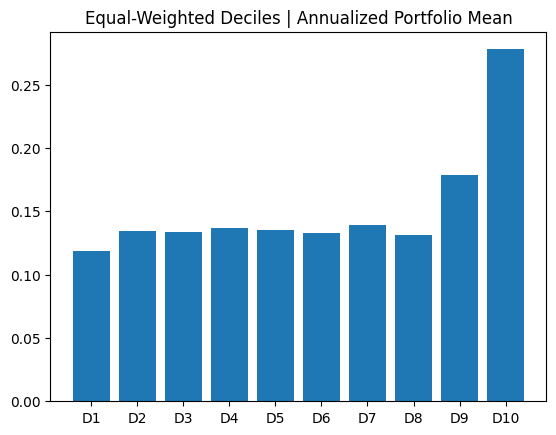

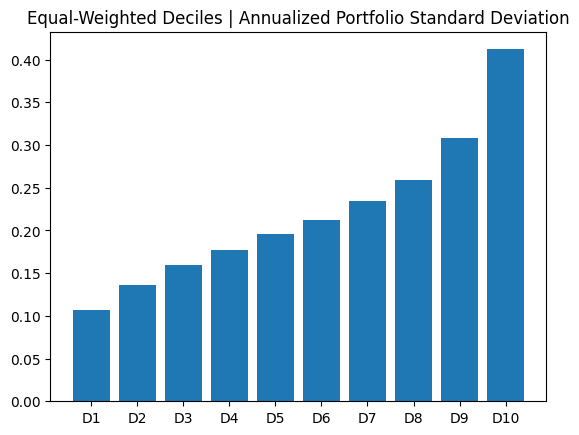

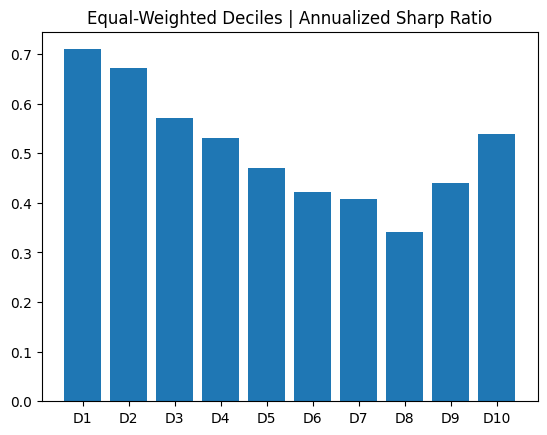

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [8]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [9]:
data_iv = data_iv.dropna(subset='idio_risk').copy()
data_iv['idio_risk_decile'] = data_iv.groupby('date')['idio_risk'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# Compute weights for value-weighted portfolios
data_iv['vw_decile'] = data_iv['mcap'] / data_iv.groupby(['date','idio_risk_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
data_iv['vw_decile_ret'] = data_iv['vw_decile'] * data_iv['Rn']
data_iv['vw_decile_excess_ret'] = data_iv['vw_decile'] * data_iv['Rn_e']
ret_vw = data_iv.groupby(['date','idio_risk_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = data_iv.groupby(['date', 'idio_risk_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw = ret_vw.merge(vw_decile_excess_ret, on=['date', 'idio_risk_decile'])
ret_vw

,date,idio_risk_decile,vw_decile_ret,vw_decile_excess_ret
0,1966-12-30,0,-0.000402,-0.004127
1,1966-12-30,1,0.017350,0.013626
2,1966-12-30,2,0.023633,0.019908
3,1966-12-30,3,0.033571,0.029847
4,1966-12-30,4,0.007837,0.004113
...,...,...,...,...
6608,2023-11-30,4,0.119225,0.114770
6609,2023-11-30,5,0.112586,0.108131
6610,2023-11-30,6,0.092796,0.088341
6611,2023-11-30,7,0.122269,0.117814


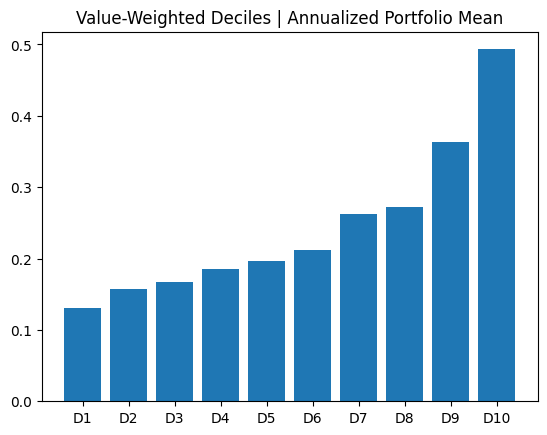

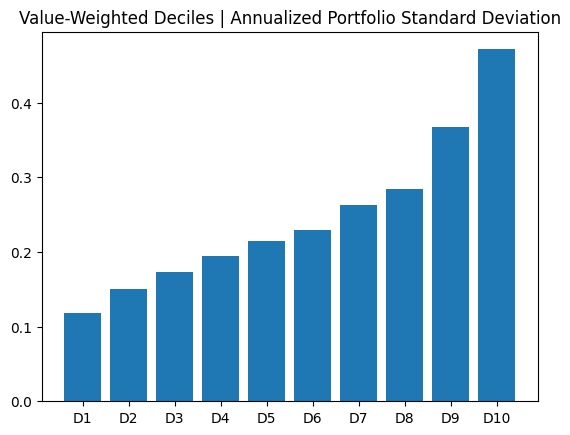

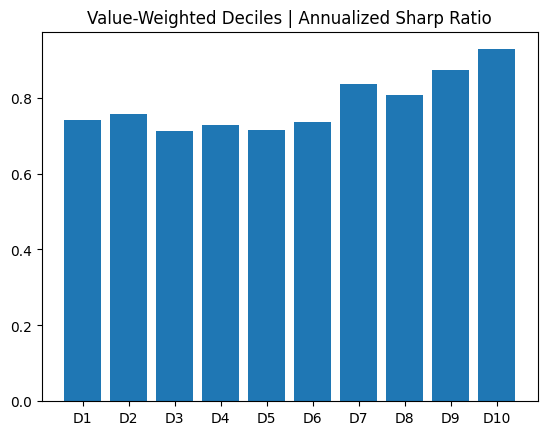

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [10]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Idiosyncratic Volatility Portfolio

In [11]:
long = data_iv[data_iv['idio_risk_decile'].isin([7,8,9])].copy()
short = data_iv[data_iv['idio_risk_decile'].isin([0,1,2])].copy()

#### Equally Weighted Portfolio

In [12]:
# Long portfolio: Equal-weighted average of the top three deciles (Deciles 7, 8 and 9)
ew_long_rets = long.groupby('date')['Rn'].mean() 
ew_long_excess_rets = long.groupby('date')['Rn_e'].mean() 
# Short portfolio: Equal-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
ew_short_rets = short.groupby('date')['Rn'].mean() 
ew_short_excess_rets = short.groupby('date')['Rn_e'].mean() 
# Compute the return of the iv strategy as the difference between the long and short portfolios' returns
ew_iv_rets = ew_long_rets - ew_short_rets

In [15]:
ew_long_mean, ew_long_std, ew_long_sharpe = calculate_portfolio_metrics(ew_long_rets, ew_long_excess_rets)
ew_short_mean, ew_short_std, ew_short_sharpe = calculate_portfolio_metrics(ew_short_rets, ew_short_excess_rets)
ew_iv_mean, ew_iv_std, ew_iv_sharpe = calculate_portfolio_metrics(ew_iv_rets, ew_long_excess_rets - ew_short_excess_rets)
ew_t_stat, ew_p_value = stats.ttest_1samp(ew_iv_rets, 0)

print(f"Equal-Weighted Portfolio Metrics:")
print(f"Long Portfolio: Mean = {ew_long_mean:.2%}, Std Dev = {ew_long_std:.2%}, Sharpe Ratio = {ew_long_sharpe:.2f}")
print(f"Short Portfolio: Mean = {ew_short_mean:.2%}, Std Dev = {ew_short_std:.2%}, Sharpe Ratio = {ew_short_sharpe:.2f}")
print(f"iv Strategy: Mean = {ew_iv_mean:.2%}, Std Dev = {ew_iv_std:.2%}, Sharpe Ratio = {ew_iv_sharpe:.2f}")
print(f"T-statistic = {ew_t_stat:.2f}, P-value = {ew_p_value:.4f}\n")

Equal-Weighted Portfolio Metrics:
Long Portfolio: Mean = 19.61%, Std Dev = 30.66%, Sharpe Ratio = 0.50
Short Portfolio: Mean = 12.84%, Std Dev = 12.86%, Sharpe Ratio = 0.66
iv Strategy: Mean = 6.77%, Std Dev = 22.49%, Sharpe Ratio = 0.30
T-statistic = 2.27, P-value = 0.0235



#### Value Weighted Portfolio

In [16]:
# Long portfolio: Value-weighted average of the top three deciles (Deciles 7, 8 and 9)
long_weights = long['mcap'] / long.groupby('date')['mcap'].transform('sum')
long['vw_rets'] = long_weights * long['Rn']
vw_long_rets = long.groupby('date')['vw_rets'].sum()
long['vw_excess_rets'] = long_weights * long['Rn_e']
vw_long_excess_rets = long.groupby('date')['vw_excess_rets'].sum()
# Short portfolio: Value-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
short_weights = short['mcap'] / short.groupby('date')['mcap'].transform('sum')
short['vw_rets'] = short_weights * short['Rn']
vw_short_rets = short.groupby('date')['vw_rets'].sum()
short['vw_excess_rets'] = short_weights * short['Rn_e']
vw_short_excess_rets = short.groupby('date')['vw_excess_rets'].sum()
# Compute the return of the iv strategy as the difference between the long and short portfolios' returns
vw_iv_rets = vw_long_rets - vw_short_rets

In [17]:
vw_long_mean, vw_long_std, vw_long_sharpe = calculate_portfolio_metrics(vw_long_rets, vw_long_excess_rets)
vw_short_mean, vw_short_std, vw_short_sharpe = calculate_portfolio_metrics(vw_short_rets, vw_short_excess_rets)
vw_iv_mean, vw_iv_std, vw_iv_sharpe = calculate_portfolio_metrics(vw_iv_rets, vw_long_excess_rets - vw_short_excess_rets)
vw_t_stat, vw_p_value = stats.ttest_1samp(vw_iv_rets, 0)

print(f"Value-Weighted Portfolio Metrics:")
print(f"Long Portfolio: Mean = {vw_long_mean:.2%}, Std Dev = {vw_long_std:.2%}, Sharpe Ratio = {vw_long_sharpe:.2f}")
print(f"Short Portfolio: Mean = {vw_short_mean:.2%}, Std Dev = {vw_short_std:.2%}, Sharpe Ratio = {vw_short_sharpe:.2f}")
print(f"iv Strategy: Mean = {vw_iv_mean:.2%}, Std Dev = {vw_iv_std:.2%}, Sharpe Ratio = {vw_iv_sharpe:.2f}")
print(f"T-statistic = {vw_t_stat:.2f}, P-value = {vw_p_value:.4f}\n")

Value-Weighted Portfolio Metrics:
Long Portfolio: Mean = 33.48%, Std Dev = 31.54%, Sharpe Ratio = 0.93
Short Portfolio: Mean = 14.57%, Std Dev = 13.25%, Sharpe Ratio = 0.78
iv Strategy: Mean = 18.91%, Std Dev = 24.39%, Sharpe Ratio = 0.78
T-statistic = 5.85, P-value = 0.0000

